In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import json
import itertools
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import requests


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [18]:
columns1 = ['video_id', 'title', 'channel_title', 'category_id',
          'tags', 'views', 'likes', 'dislikes', 'comment_total',
          'thumbnail_link', 'date']
vid_df =  pd.read_csv("C:/Users/Vishaal/Desktop/IDS Final/USvideos.csv", usecols = columns1)
vid_df = vid_df.dropna()

columns2 = ['video_id', 'comment_text', 'likes', 'replies']

comm_df =  pd.read_csv("C:/Users/Vishaal/Desktop/IDS Final/UScomments.csv", usecols = columns2, low_memory=False)
comm_df = comm_df.dropna()

In [19]:
vid_df.category_id = pd.Categorical(vid_df.category_id)

In [20]:
#Some dates seem to be messed up. We shall replace them with something more meaningful
vid_df['date'].unique()

array(['13.09', '14.09', '15.09', '16.09', '17.09', '18.09', '19.09',
       '20.09', '21.09', '22.09', '23.09', '24.09', '24.09xcaeyJTx4Co',
       '25.09', '26.09', '26.0903jeumSTSzc', '27.09', '28.09', '29.09',
       '30.09', '01.10', '02.10', '03.10', '04.10', '05.10', '06.10',
       '07.10', '08.10', '09.10', '100', '10.10', '11.10', '12.10',
       '13.10', '14.10', '15.10', '16.10', '17.10', '18.10', '19.10',
       '20.10', '21.10', '22.10'], dtype=object)

In [21]:
#Comments have emojis! Hope VADER can handle emojis...
comm_df.iloc[41587, ]






video_id                                              _ANP3HR1jsM
comment_text    My dad raised Razor's Edge Pitbulls. If you fa...
likes                                              FoxSearchlight
replies                                                         1
Name: 41587, dtype: object

In [23]:
#Removing wrong entries in the reply column. Converting all to int...
comm_df.drop(41587, inplace=True)
comm_df.drop(41588, inplace=True)
comm_df.drop(51626, inplace=True)
comm_df.drop(142419, inplace=True)
comm_df.drop(142494, inplace=True)
comm_df.drop(189730, inplace=True)
comm_df.drop(245216, inplace=True)
comm_df.drop(114463, inplace=True)
comm_df.drop(388428, inplace=True)


In [24]:
comm_df.replies = pd.to_numeric(comm_df.replies)
comm_df.likes = pd.to_numeric(comm_df.likes)

In [25]:
#Correcting the dates in vid_df
vid_df.loc[vid_df['date'] == '24.09xcaeyJTx4Co', 'date'] = '24.09'
vid_df.loc[vid_df['date'] == '26.0903jeumSTSzc', 'date'] = '26.09'
vid_df.loc[vid_df['date'] == '100', 'date'] = '09.10'

In [26]:
#We also change the date format...code from kaggle...
vid_df['date'] = vid_df['date'].apply(lambda x: pd.to_datetime(str(x).replace('.','')+"2017",format='%d%m%Y'))
vid_df['date'] = vid_df['date'].dt.date

In [27]:
vid_df['L/D'] = vid_df.likes/vid_df.dislikes
vid_df.drop(vid_df[vid_df['L/D'] == float('inf')].index, inplace=True)
vid_df.dropna(inplace=True)
vid_df[vid_df.video_id == 'CAQ2wWVlOuc']
vid_df[vid_df.video_id == 'CAQ2wWVlOuc'].to_csv('C:/Users/Vishaal/Desktop/IDS Final/bezos.csv', encoding='utf-8', index=False)

In [28]:
#Let's creat a new column called L/D..also let get rid of the duplicates... based on video_id
video_df = vid_df.drop_duplicates(subset = 'video_id', inplace = False, keep = 'last')
vid_df_1 = video_df[video_df['category_id'] == 24]

In [29]:
#There are 73 videos with no dislikes....hmmmm...

len(video_df[video_df['L/D'] == float('inf')])

0

Text(0, 0.5, 'Views(in m)')

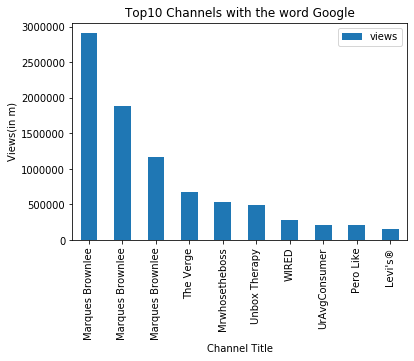

In [30]:
#Code sourced from kaggle - to see which channels have a certain trending word
tag_top = video_df[video_df['title'].str.contains('Google')].sort_values(by='views', ascending=False).head(10)
ax = tag_top.plot(kind='bar',x='channel_title',y='views',title='Top10 Channels with the word Google')
ax.set_xlabel('Channel Title')
ax.set_ylabel('Views(in m)')
#plt.savefig('D:/IDS 702 Final Project/youtube/foo.png')

In [31]:
#Good thing that the number of unique videos in comments dataset is less than that in video dataset. As expected. 
len(video_df.video_id.unique())
len(comm_df.video_id.unique())

2266

In [32]:
#Bunch of duplicates though in the video dataset..... same video uploaded multiple times. This could be because of copyright etc. Wd shall simply drop the duplicates. 
len(video_df.video_id)

2280

In [33]:
#A left join makes the most sense here. Let all the video data survive. This is at the comment level.
merged_left_24 = pd.merge(left=vid_df_1,right=comm_df, how='left', left_on='video_id', right_on='video_id', validate = '1:m')
merged_left = pd.merge(left=video_df,right=comm_df, how='left', left_on='video_id', right_on='video_id', validate = '1:m')


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text yticklabel objects>)

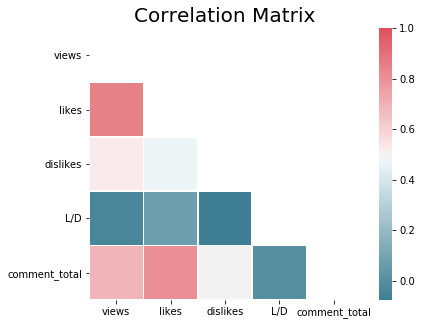

In [34]:
corr_us = video_df.loc[:,['views', 'likes', 'dislikes', 'L/D', 'comment_total']].corr()
mask = np.zeros_like(corr_us, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax2 = plt.subplot(gs[0,1])
ax1 = sns.heatmap(corr_us, cmap=cmap, vmax=1, center=0.5,
                  square=True, linewidths=.5, mask=mask)
ax2.set_title('Correlation Matrix', fontsize=20)
plt.yticks(rotation=0)



In [35]:
#Now we do the text analysis on all the comments using vader...
sid_obj = SentimentIntensityAnalyzer() 

score = []
p = []
neu = []
neg = []
compound = []

for sentence in merged_left.comment_text:
        sentiment_dict = sid_obj.polarity_scores(str(sentence)) 
        score.append(sentiment_dict)
        p.append(sentiment_dict['pos'])
        neg.append(sentiment_dict['neg'])
        neu.append(sentiment_dict['neu'])
        compound.append(sentiment_dict['compound'])

In [36]:
merged_left['poitive_score'] = p
merged_left['negative_score'] = neg
merged_left['neutral_score'] = neu
merged_left['compound_score'] = compound


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text yticklabel objects>)

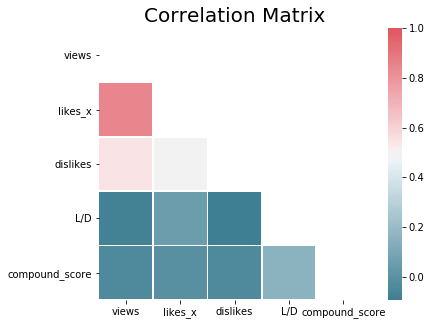

In [37]:
corr_us = merged_left.loc[:,[ 'views','likes_x', 'dislikes', 'L/D', 'compound_score']].corr()
mask = np.zeros_like(corr_us, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax2 = plt.subplot(gs[0,1])
ax1 = sns.heatmap(corr_us, cmap=cmap, vmax=1, center=0.5,
                  square=True, linewidths=.5, mask=mask)
ax2.set_title('Correlation Matrix', fontsize=20)
plt.yticks(rotation=0)

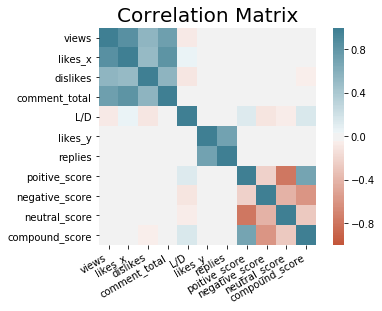

In [38]:

corr = merged_left.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True

)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=30,
    horizontalalignment='right'
);
ax.set_title('Correlation Matrix', fontsize=20)
plt.savefig('C:/Users/Vishaal/Desktop/IDS Final/correlation.png')

In [39]:
merged_left = merged_left[~merged_left['channel_title'].isin(['The Daily Show with Trevor Noah' , 'CNN', 'ABC News', 'Cardi B', 'MILO', 'Logan Paul Vlogs', 'WatchMojo.com', 'LegallyArmedAmerica', 'ProPublica', 'Courageous Conservatives PAC'])]

merged_left.shape

(681461, 19)

In [40]:
df1 = merged_left.groupby([ 'video_id', 'category_id'], as_index = False).mean()


In [41]:
df2 = merged_left.groupby( 'category_id', as_index = False).mean()


In [44]:
comm_pos1 = merged_left[merged_left.compound_score==-0.9].sample(2)


In [ ]:
comm_pos1.to_csv('C:/Users/Vishaal/Desktop/IDS Final/comm_neg1.csv', encoding='utf-8', index=False)

In [ ]:
#merged_left_24.to_csv('D:/IDS 702 Final Project/youtube/merged.csv', encoding='utf-8', index=False)

In [45]:
df1.to_csv('C:/Users/Vishaal/Desktop/IDS Final/df_average_compound_score_bycategory(many Nans)1.csv', encoding='utf-8', index=False)

In [46]:
df2.to_csv('C:/Users/Vishaal/Desktop/IDS Final/boxplot_dataframe_by_categry_id1.csv', encoding='utf-8', index=False)

In [47]:
#Grouped by channel title
df3 = merged_left.groupby( ['channel_title', 'category_id'], as_index = False).mean()
df3.sort_values('compound_score', inplace = True)



In [48]:
df3_sort = df3.sort_values('compound_score')
df3_select = df3[df3['channel_title'].isin(['The Daily Show with Trevor Noah' , 'CNN', 'ABC News', 'Cardi B', 'MILO', 'Logan Paul Vlogs', 'WatchMojo.com', 'LegallyArmedAmerica', 'ProPublica', 'Courageous Conservatives PAC'])]
                
#df3_select

In [49]:
df3_select.to_csv('C:/Users/Vishaal/Desktop/IDS Final/controversial1.csv', encoding='utf-8', index=False)

In [50]:
idx = merged_left.groupby(['title'])['likes_y'].transform(max) == merged_left['likes_y']
cor = merged_left[idx]


In [51]:
df5 = cor.groupby( 'title', as_index = False).mean()

In [52]:
#Now we do the text analysis on all the comments using vader...
sid_obj_com = SentimentIntensityAnalyzer() 

score_com = []
p_com = []
neu_com = []
neg_com = []
compound_com = []

for sentence in df5.title:
        sentiment_dict_com = sid_obj_com.polarity_scores(str(sentence)) 
        score_com.append(sentiment_dict_com)
        p_com.append(sentiment_dict_com['pos'])
        neg_com.append(sentiment_dict_com['neg'])
        neu_com.append(sentiment_dict_com['neu'])
        compound_com.append(sentiment_dict_com['compound'])

In [53]:

df5['compound_score_comm'] = compound_com

In [54]:
df5.to_csv('C:/Users/Vishaal/Desktop/IDS Final/comment_corr.csv', encoding='utf-8', index=False)

In [55]:
idx1 = merged_left.groupby(['title'])['likes_y'].transform(max) == merged_left['likes_y']
cor1 = merged_left[~idx1]

In [56]:
df6 = cor1.groupby( 'title', as_index = False).mean()

In [57]:
del df5['compound_score_comm']

In [58]:
df6.shape

(2236, 12)

In [59]:
df7 = df6[df6.title.isin(df5.title.values)]

In [60]:
df7.shape

(2172, 12)

In [61]:
df7.to_csv('C:/Users/Vishaal/Desktop/IDS Final/other_comm.csv', encoding='utf-8', index=False)